In [1]:
%matplotlib inline

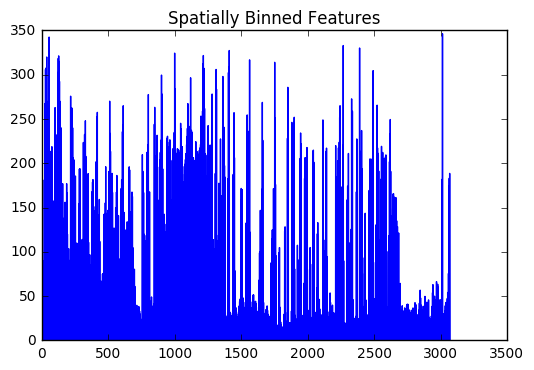

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in an image
# You can also read cutout2, 3, 4 etc. to see other examples
image = mpimg.imread('./vehicle_test/7.png')

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space == 'HSV':
        img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        img = cv2.cvtColor(img,cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() # Remove this line!
    # Return the feature vector
    return features
    
feature_vec = bin_spatial(image, color_space='HLS', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

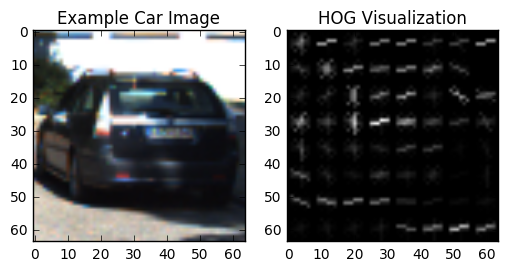

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog

# Read in our vehicles and non-vehicles
images = glob.glob('./vehicle_test/*.png')
cars = []

for image in images:
    cars.append(image)
        
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=feature_vec)
        # features = [] # Remove this line
        # hog_image = img # Remove this line
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features,_ = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=feature_vec)
        # features = [] # Remove this line
        return features

# Generate a random index to look at a car image
# ind = np.random.randint(0, len(cars))
ind=0
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')


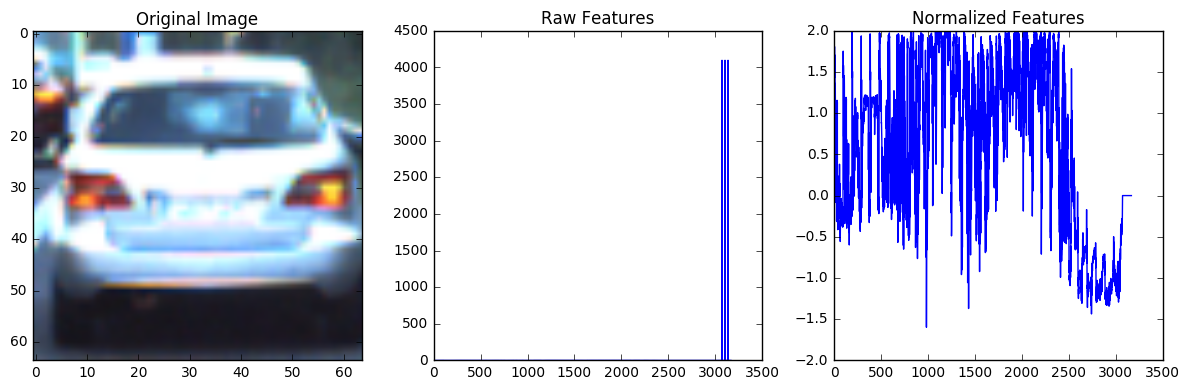

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

# Read in our vehicles and non-vehicles
images = glob.glob('./vehicle_test/*.png')
cars = []

for image in images:
    cars.append(image)
        
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
# notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
#                         hist_bins=32, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
#     X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    X = car_features                       
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

(3072,)
(96,)
(1764,)
-------------
(1, 4932)
(3072,)
(96,)
(1764,)
-------------
(2, 4932)
(3072,)
(96,)
(1764,)
-------------
(3, 4932)
(3072,)
(96,)
(1764,)
-------------
(4, 4932)
(3072,)
(96,)
(1764,)
-------------
(5, 4932)


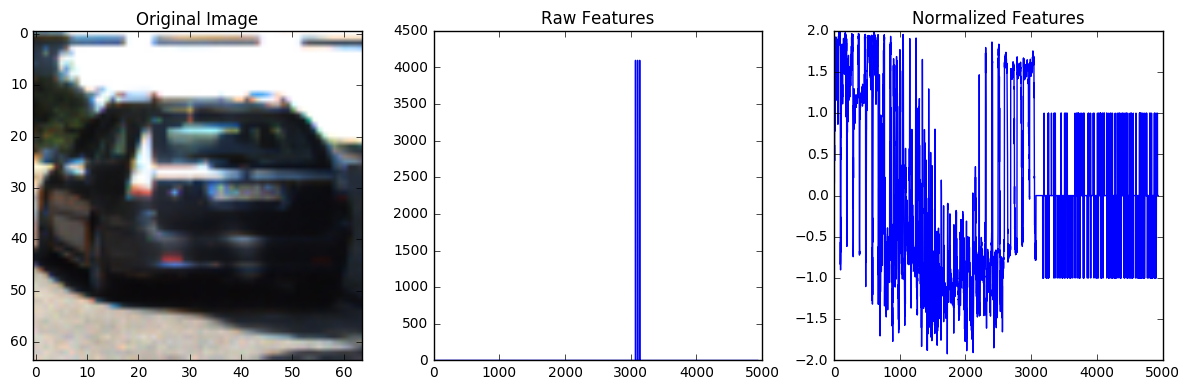

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                  cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=feature_vec)
        # features = [] # Remove this line
        # hog_image = img # Remove this line
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                         cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=feature_vec)
        # features = [] # Remove this line
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Call our function with vis=True to see an image output
        # Define HOG parameters
        orient = 9
        pix_per_cell = 8
        cell_per_block = 2
        hog_features, _ = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
        # Append the new feature vector to the features list
        print(spatial_features.shape)
        print(hist_features.shape)
        print(hog_features.shape)
        print("-------------")
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        print(np.array(features).shape)
        print("=============")
    # Return list of feature vectors
    return features

# Read in our vehicles and non-vehicles
images = glob.glob('./vehicle_test/*.png')
cars = []

for image in images:
    cars.append(image)
        
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
# notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
#                         hist_bins=32, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
#     X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    X = car_features                       
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

In [6]:
# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt
# import numpy as np
# import cv2
# import glob
# import time
# from sklearn.svm import LinearSVC
# from sklearn.preprocessing import StandardScaler
# # NOTE: the next import is only valid 
# # for scikit-learn version <= 0.17
# # if you are using scikit-learn >= 0.18 then use this:
# # from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
# from sklearn.externals import joblib

# # Define a function to compute binned color features  
# def bin_spatial(img, size=(32, 32)):
#     # Use cv2.resize().ravel() to create the feature vector
#     features = cv2.resize(img, size).ravel() 
#     # Return the feature vector
#     return features

# # Define a function to compute color histogram features  
# def color_hist(img, nbins=32, bins_range=(0, 256)):
#     # Compute the histogram of the color channels separately
#     channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
#     channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
#     channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
#     # Concatenate the histograms into a single feature vector
#     hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
#     # Return the individual histograms, bin_centers and feature vector
#     return hist_features


# def img_features(image, cspace='RGB', spatial_size=(32, 32),
#                         hist_bins=32, hist_range=(0, 256)):
#     # apply color conversion if other than 'RGB'
#     if cspace != 'RGB':
#         if cspace == 'HSV':
#             feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#         elif cspace == 'LUV':
#             feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
#         elif cspace == 'HLS':
#             feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#         elif cspace == 'YUV':
#             feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#     else: feature_image = np.copy(image)      
#     # Apply bin_spatial() to get spatial color features
#     spatial_features = bin_spatial(feature_image, size=spatial_size)
#     # Apply color_hist() also with a color space option now
#     hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
#     return spatial_features, hist_features


# # Define a function to extract features from a list of images
# # Have this function call bin_spatial() and color_hist()
# def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
#                         hist_bins=32, hist_range=(0, 256)):
#     # Create a list to append feature vectors to
#     features = []
#     # Iterate through the list of images
#     for file in imgs:
#         # Read in each one by one
#         image = mpimg.imread(file)
#         spatial_features, hist_features = img_features(image, cspace='RGB', spatial_size=(32, 32),
#                                                        hist_bins=32, hist_range=(0, 256))
#         # Append the new feature vector to the features list
#         features.append(np.concatenate((spatial_features, hist_features)))
#     # Return list of feature vectors
#     return features


# # Read in car and non-car images
# print("Reading in images...")
# car_images = glob.glob('./vehicles/GTI_Far/*.png') + glob.glob('./vehicles/GTI_Left/*.png') + glob.glob('./vehicles/GTI_MiddleClose/*.png')+ glob.glob('./vehicles/GTI_Right/*.png') + glob.glob('./vehicles/KITTI_extracted/*.png')
# print("# car images: " + str(len(car_images)))

# non_car_images = glob.glob('./non-vehicles/GTI/*.png')+glob.glob('./non-vehicles/Extras/*.png')
# non_car_images = non_car_images[:len(car_images)]
# print("# non-car images: " + str(len(non_car_images)))
    
# cars = []
# notcars = []

# for car_image in car_images:
#     cars.append(car_image)

# for non_car_image in non_car_images:
#     notcars.append(non_car_image)

# # TODO play with these values to see how your classifier
# # performs under different binning scenarios
# spatial = 32
# histbin = 32
# colorsp = 'RGB'
# print("Extracting features...")
# car_features = extract_features(cars, cspace=colorsp, spatial_size=(spatial, spatial),
#                         hist_bins=histbin, hist_range=(0, 256))
# notcar_features = extract_features(notcars, cspace=colorsp, spatial_size=(spatial, spatial),
#                         hist_bins=histbin, hist_range=(0, 256))

# # Create an array stack of feature vectors
# print("Scale the features...")
# X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# # Fit a per-column scaler
# X_scaler = StandardScaler().fit(X)
# # Apply the scaler to X
# scaled_X = X_scaler.transform(X)

# # Define the labels vector
# y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# # Split up data into randomized training and test sets
# print("Creating validation set...")
# rand_state = np.random.randint(0, 100)
# X_train, X_test, y_train, y_test = train_test_split(
#     scaled_X, y, test_size=0.2, random_state=rand_state)

# print('Using spatial binning of:',spatial,
#     'and', histbin,'histogram bins')
# print('Feature vector length:', len(X_train[0]))
# # Use a linear SVC 
# svc = LinearSVC()
# # Check the training time for the SVC
# t=time.time()
# svc.fit(X_train, y_train)
# t2 = time.time()
# print(round(t2-t, 2), 'Seconds to train SVC...')
# # Check the score of the SVC
# print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# # Check the prediction time for a single sample
# t=time.time()
# n_predict = 15
# print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
# print('For these',n_predict, 'labels: ', y_test[0:n_predict])
# t2 = time.time()
# print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# print("Saving model...")
# # joblib.dump(svc, './svc_color_classify.pkl') 
# # clf = joblib.load('filename.pkl') 


In [7]:
# svc_loaded = joblib.load('./svc_color_classify.pkl') 
# t=time.time()
# n_predict = 15
# begin = np.random.randint(len(X_test))
# end = begin + n_predict
# print('My SVC predicts:     ', svc_loaded.predict(X_test[begin:end]))
# print('For these',n_predict, 'labels: ', y_test[begin:end])
# t2 = time.time()
# print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [8]:
# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt
# import numpy as np
# import cv2
# import glob
# import time
# from sklearn.svm import LinearSVC
# from sklearn.preprocessing import StandardScaler
# from skimage.feature import hog
# # NOTE: the next import is only valid for scikit-learn version <= 0.17
# # for scikit-learn >= 0.18 use:
# # from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
# from sklearn.externals import joblib


# # Define a function to return HOG features and visualization
# def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
#                         vis=False, feature_vec=True):
#     # Call with two outputs if vis==True
#     if vis == True:
#         features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
#                                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
#                                   visualise=vis, feature_vector=feature_vec)
#         return features, hog_image
#     # Otherwise call with one output
#     else:      
#         features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
#                        cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
#                        visualise=vis, feature_vector=feature_vec)
#         return features

# # Define a function to extract features from a list of images
# # Have this function call bin_spatial() and color_hist()
# def extract_hog_features(imgs, cspace='RGB', orient=9, 
#                         pix_per_cell=8, cell_per_block=2, hog_channel=0):
#     # Create a list to append feature vectors to
#     features = []
#     # Iterate through the list of images
#     for file in imgs:
#         # Read in each one by one
#         image = mpimg.imread(file)
#         # apply color conversion if other than 'RGB'
#         if cspace != 'RGB':
#             if cspace == 'HSV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#             elif cspace == 'LUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
#             elif cspace == 'HLS':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#             elif cspace == 'YUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#             elif cspace == 'YCrCb':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
#         else: feature_image = np.copy(image)      

#         # Call get_hog_features() with vis=False, feature_vec=True
#         if hog_channel == 'ALL':
#             hog_features = []
#             for channel in range(feature_image.shape[2]):
#                 hog_features.append(get_hog_features(feature_image[:,:,channel], 
#                                     orient, pix_per_cell, cell_per_block, 
#                                     vis=False, feature_vec=True))
#             hog_features = np.ravel(hog_features)        
#         else:
#             hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
#                         pix_per_cell, cell_per_block, vis=False, feature_vec=True)
#         # Append the new feature vector to the features list
#         features.append(hog_features)
#     # Return list of feature vectors
#     return features


# # Read in car and non-car images
# print("Reading in images...")
# car_images = glob.glob('./vehicles/GTI_Far/*.png') + glob.glob('./vehicles/GTI_Left/*.png') + glob.glob('./vehicles/GTI_MiddleClose/*.png')+ glob.glob('./vehicles/GTI_Right/*.png') + glob.glob('./vehicles/KITTI_extracted/*.png')
# print("# car images: " + str(len(car_images)))

# non_car_images = glob.glob('./non-vehicles/GTI/*.png')+glob.glob('./non-vehicles/Extras/*.png')
# non_car_images = non_car_images[:len(car_images)]
# print("# non-car images: " + str(len(non_car_images)))
    
# cars = []
# notcars = []

# for car_image in car_images:
#     cars.append(car_image)

# for non_car_image in non_car_images:
#     notcars.append(non_car_image)

# # Reduce the sample size because HOG features are slow to compute
# # The quiz evaluator times out after 13s of CPU time
# # sample_size = 500
# # cars = cars[0:sample_size]
# # notcars = notcars[0:sample_size]

# ### TODO: Tweak these parameters and see how the results change.
# colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9
# pix_per_cell = 8
# cell_per_block = 2
# hog_channel = 0 # Can be 0, 1, 2, or "ALL"

# t=time.time()
# car_features = extract_hog_features(cars, cspace=colorspace, orient=orient, 
#                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel)
# notcar_features = extract_hog_features(notcars, cspace=colorspace, orient=orient, 
#                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel)
# t2 = time.time()
# print(round(t2-t, 2), 'Seconds to extract HOG features...')
# # Create an array stack of feature vectors
# X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# # Fit a per-column scaler
# X_scaler = StandardScaler().fit(X)
# # Apply the scaler to X
# scaled_X = X_scaler.transform(X)

# # Define the labels vector
# y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# # Split up data into randomized training and test sets
# rand_state = np.random.randint(0, 100)
# X_train, X_test, y_train, y_test = train_test_split(
#     scaled_X, y, test_size=0.2, random_state=rand_state)

# print('Using:',orient,'orientations',pix_per_cell,
#     'pixels per cell and', cell_per_block,'cells per block')
# print('Feature vector length:', len(X_train[0]))
# # Use a linear SVC 
# svc = LinearSVC()
# # Check the training time for the SVC
# t=time.time()
# svc.fit(X_train, y_train)
# t2 = time.time()
# print(round(t2-t, 2), 'Seconds to train SVC...')
# # Check the score of the SVC
# print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# # Check the prediction time for a single sample
# t=time.time()
# n_predict = 10
# print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
# print('For these',n_predict, 'labels: ', y_test[0:n_predict])
# t2 = time.time()
# print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# print("Saving model...")
# # joblib.dump(svc, './svc_hog_classify.pkl') 
# # clf = joblib.load('filename.pkl') 

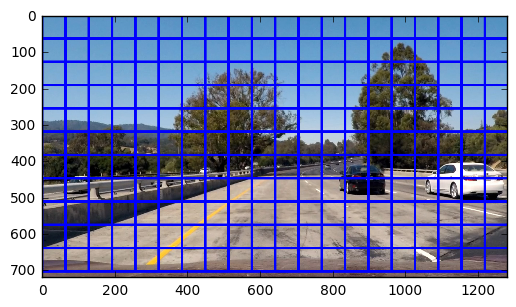

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('./test_images/test1.jpg')

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # print(bbox)
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    x_span = x_start_stop[1] - x_start_stop[0]
    y_span = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    pixels_p_step_x = np.int(xy_window[0]*(1 - xy_overlap[0]))
    pixels_p_step_y = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    n_windows_x = np.int((x_span-nx_buffer) / pixels_p_step_x)
    n_windows_y = np.int((y_span-ny_buffer) / pixels_p_step_y)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
    for j in range(0,n_windows_y):
        for i in range(0, n_windows_x):
            # Calculate each window position
            startx = i*pixels_p_step_x + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = j*pixels_p_step_y + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
# for w in windows:
#     print(w)
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

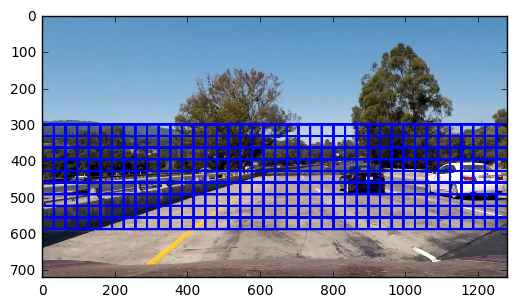

In [10]:
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[300, 600], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
# for w in windows:
#     print(w)
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

Using: 12 orientations 8 pixels per cell and 2 cells per block


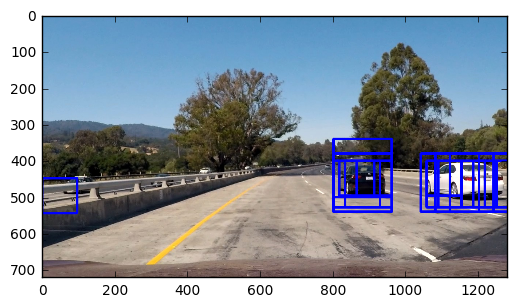

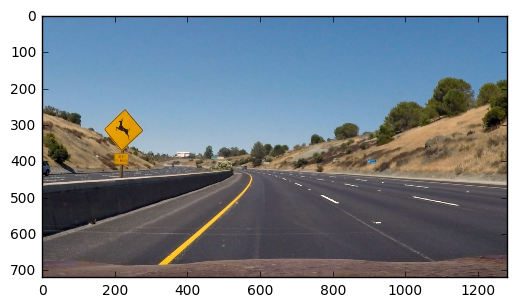

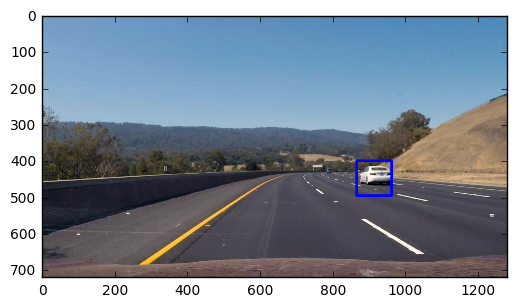

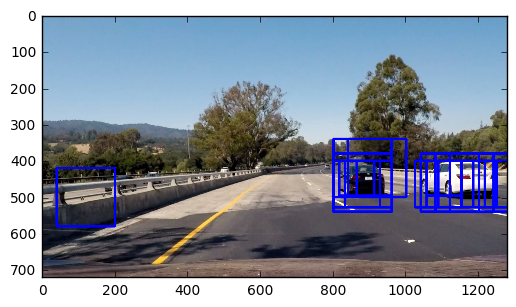

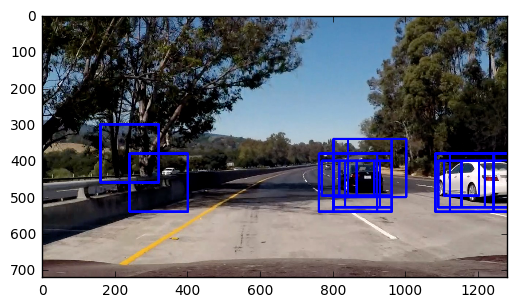

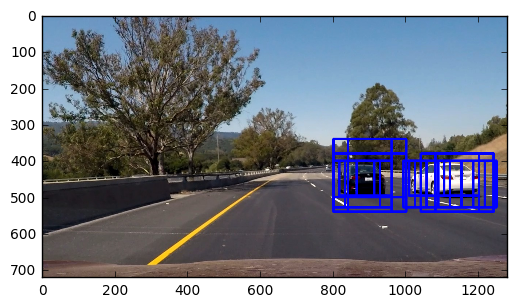

In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib

# Define a function to extract features from a single image window

%matplotlib inline
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 700] # Min and max in y to search in slide_window()


# Fit a per-column scaler
X_scaler = joblib.load('./scaler_YCrCb_HOG-ALL_featlen_10224.pkl') 

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
# print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = joblib.load('./svc_YCrCb_HOG-ALL_featlen_10224.pkl') 

# Check the score of the SVC
# print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
# t=time.time()

images = glob.glob('./test_images/*.jpg')

for img_file in images:

    image = mpimg.imread(img_file)
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    windows_1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,600], 
                        xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    windows_2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,700], 
                        xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    windows_3 = slide_window(image, x_start_stop=[None, None], y_start_stop=[300,700], 
                        xy_window=(160, 160), xy_overlap=(0.75, 0.75))
    
    windows = windows_1 + windows_2 + windows_3

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    plt.imshow(window_img)
    plt.show()

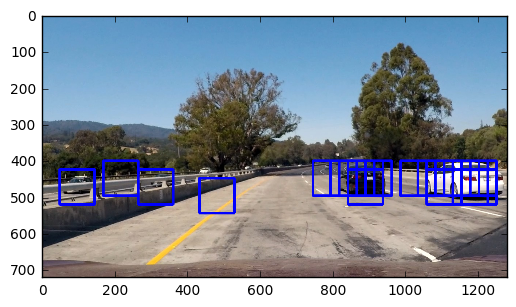

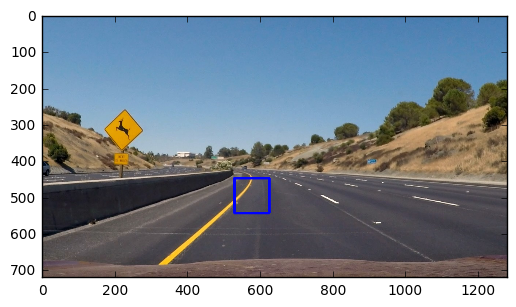

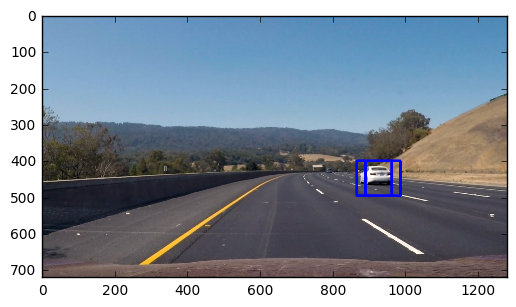

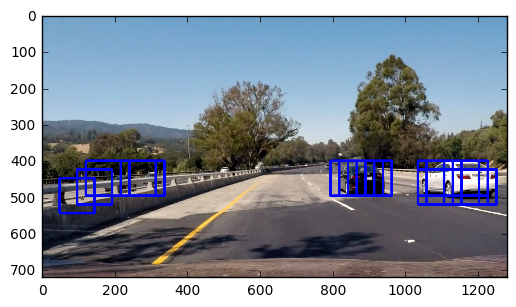

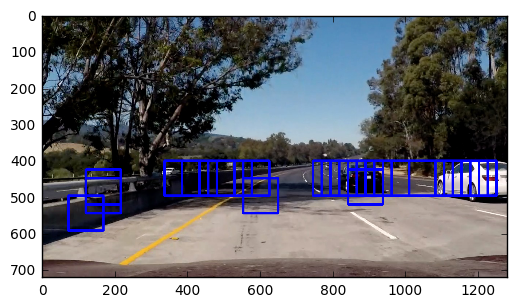

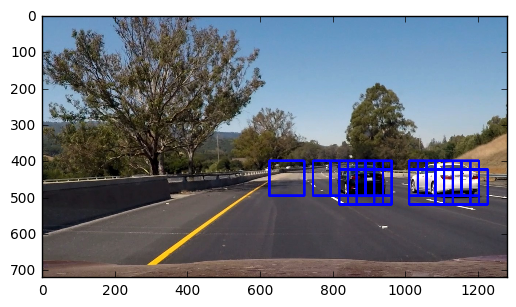

In [12]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from lesson_functions import *

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

svc = joblib.load('./svc_YCrCb_HOG-ALL_featlen_10224.pkl') 
X_scaler = joblib.load('./scaler_YCrCb_HOG-ALL_featlen_10224.pkl') 

# svc = joblib.load('./svc_augmented_YCrCb_HOG-ALL_featlen_10224.pkl') 
# X_scaler = joblib.load('./scaler_augmented_YCrCb_HOG-ALL_featlen_10224.pkl') 


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1.5

images = glob.glob('./test_images/*.jpg')

for img_file in images:
    img = mpimg.imread(img_file)

    out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    plt.imshow(out_img)
    plt.show()

In [13]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_boxes(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    boxes = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return boxes
    

19
2
9
21
22
19


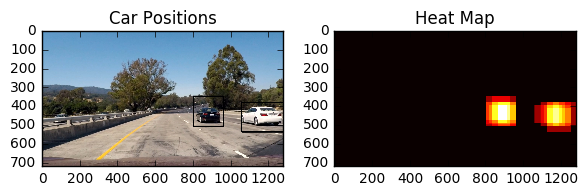

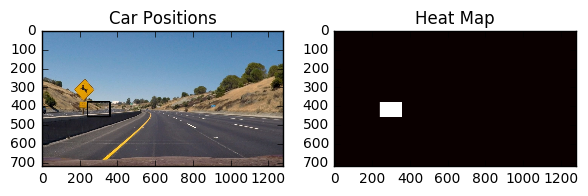

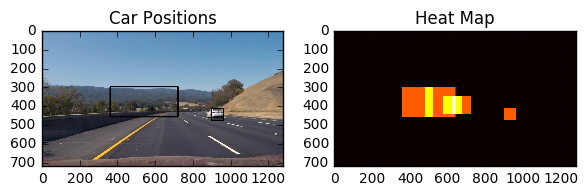

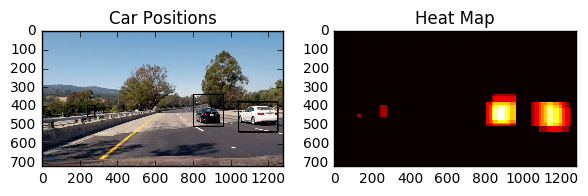

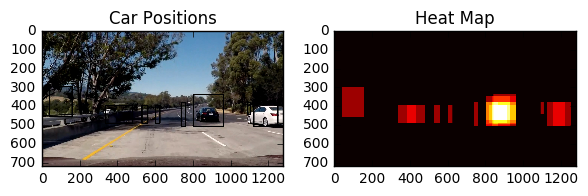

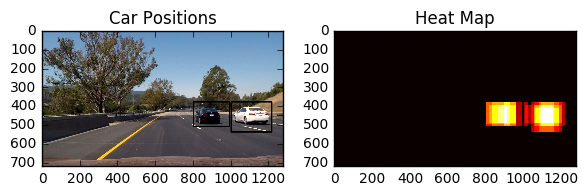

In [14]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label




def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


images = glob.glob('./test_images/*.jpg')

for img_file in images:
    image = mpimg.imread(img_file)
    image = image.astype(np.float32)/255
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)


    # Read in a pickle file with bboxes saved
    # Each item in the "all_bboxes" list will contain a 
    # list of boxes for one of the images shown above
    windows_0 = slide_window(image, x_start_stop=[None, None], y_start_stop=[350,550], 
                            xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    windows_1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[350,600], 
                            xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    windows_2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[350,700], 
                        xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    windows_3 = slide_window(image, x_start_stop=[None, None], y_start_stop=[300,700], 
                        xy_window=(160, 160), xy_overlap=(0.75, 0.75))

    windows = windows_0 + windows_1 + windows_2 + windows_3

    box_list = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
#     box_list = find_boxes(image, 350, 700, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     


    print(len(box_list))


    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()


In [15]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_heat(img, scale):
  
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
    return heatmap
    

In [16]:
class VehicleDetection:

    heatmaps = []
    n_heatmaps = 1
    heat_threshold = 1
    
    def __init__(self, n_heatmaps=1, heat_threshold=1):
        self.heatmaps = []
        self.n_heatmaps=n_heatmaps
        self.heat_threshold = heat_threshold
        
    def add_heatmap(self, heatmap):
        self.heatmaps.append(heatmap)
        if len(self.heatmaps)>self.n_heatmaps:
            self.heatmaps=self.heatmaps[-self.n_heatmaps:]
            
    def get_av_heatmap(self):
        return np.mean(self.heatmaps,axis=0)
    
    def get_sum_heatmap(self):
        return np.sum(self.heatmaps,axis=0)
    
    def process_image(self, image):

        heat1 = find_cars_heat(image, 1)
        heat2 = find_cars_heat(image, 1.5)
        heat3 = find_cars_heat(image, 2)
#         heat_av = np.mean([heat1,heat2,heat3],axis=0)
        heat_sum = cv2.add(cv2.add(heat1,heat2),heat3)
        self.add_heatmap(heat_sum)
#         self.add_heatmap(heat_av)
#         heat = self.get_av_heatmap()    
        heat = self.get_sum_heatmap() 
    
#         print(len(self.heatmaps))
        #     heat = find_cars_heat(image, 1.5)

        # Apply threshold to help remove false positives
#         heat = apply_threshold(heat,1)
        heat = apply_threshold(heat,self.heat_threshold)

        # Visualize the heatmap when displaying    
        heat_map = np.clip(heat, 0, 255)
        labels = label(heat_map)
        # Draw bounding boxes on a copy of the image
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
        return draw_img#, heat_map
    
    def process_image_2(self,orig_image):
            
        image = orig_image.copy().astype(np.float32)/255

        heat = np.zeros_like(image[:,:,0]).astype(np.float)


        # Read in a pickle file with bboxes saved
        # Each item in the "all_bboxes" list will contain a 
        # list of boxes for one of the images shown above
#         windows_0 = slide_window(image, x_start_stop=[None, None], y_start_stop=[350,550], 
#                                 xy_window=(64, 64), xy_overlap=(0.5, 0.5))
#         windows_1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,600], 
#                                 xy_window=(96, 96), xy_overlap=(0.75, 0.75))
        windows_1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,600], 
                                xy_window=(96, 96), xy_overlap=(0.8, 0.8))
#         windows_2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[350,700], 
#                             xy_window=(128, 128), xy_overlap=(0.75, 0.75))
#         windows_3 = slide_window(image, x_start_stop=[None, None], y_start_stop=[300,700], 
#                             xy_window=(160, 160), xy_overlap=(0.75, 0.75))

        windows = windows_1 #windows_0 + windows_1 + windows_2 + windows_3

        box_list = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)

        # Add heat to each box in box list
        heat_sum = add_heat(heat,box_list)
        
        self.add_heatmap(heat_sum)
        heat = self.get_sum_heatmap() 

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,self.heat_threshold)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(orig_image), labels)
        
        return draw_img


In [17]:
# images = glob.glob('./test_images/*.jpg')

# for img_file in images:
#     image = mpimg.imread(img_file)

#     vd = VehicleDetection()
#     proc = vd.process_image_2(image.copy())

#     fig = plt.figure()
# #     plt.subplot(121)
#     plt.imshow(proc)
#     plt.title('Car Positions')
# #     plt.subplot(122)
# #     plt.imshow(heat, cmap='hot')
# #     plt.title('Heat Map')
# #     fig.tight_layout()

In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

vd = VehicleDetection(25,15)
test_output = './test_video_result.mp4'
clip = VideoFileClip('./test_video.mp4')
test_clip = clip.fl_image(vd.process_image_2)

test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video ./test_video_result.mp4
[MoviePy] Writing video ./test_video_result.mp4


 97%|████████████████████████████████████████▉ | 38/39 [02:02<00:03,  3.46s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_result.mp4 



In [20]:
# from moviepy.editor import VideoFileClip
# from IPython.display import HTML

vd = VehicleDetection(25,15)
test_output = './project_video_result.mp4'
clip = VideoFileClip('./project_video.mp4')
test_clip = clip.fl_image(vd.process_image_2)

test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video ./project_video_result.mp4
[MoviePy] Writing video ./project_video_result.mp4


100%|███████████████████████████████████▉| 1260/1261 [1:07:56<00:02,  2.98s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_result.mp4 

